In [1016]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('text', usetex=True)
rc('figure', facecolor='w')
import astropy.io.fits as fits
from astropy.nddata import Cutout2D
import math, os
from natsort import natsorted
from scipy.stats import poisson

In [446]:
def mean(array):
    return np.sum(array)/len(array)

def stdev(array):
#     return np.sqrt(np.abs(mean(array)**2 - mean(array**2)))
    return np.sqrt(sum((array - mean(array))**2)/(len(array) - 1))

def median(array):
    percentile50 = int(np.round(len(array)/2))
   
    return sorted(array)[percentile50]

In [1105]:
def factorial(n, **kwargs):
    
    method = kwargs.get('method', 'sterling')
    
    if method == 'exact':
        nfact = 1
        for i in range(n):
            nfact *= (i+1)
    # sterling approximation
    elif method == 'sterling': 
        nfact = math.sqrt(2*math.pi) * n**(n+.5) / math.e**n
        
    return nfact

def poisson_approx(data, mean, **kwargs):
    
    method = kwargs.get('method')
    
#     pdist = np.array([mu**x/factorial(x, method=method) * math.e**(-mu) for x in xarray])
    pdist = np.array(np.exp((data*np.log(mean))-(data*np.log(data))+data-mean))
    
    return pdist

def gaussian(data,mean,sigma):
    
    return np.array((1/(sigma*(2*math.pi)**(.5)))*np.exp(-.5*((data-mean)/sigma)**2))


/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


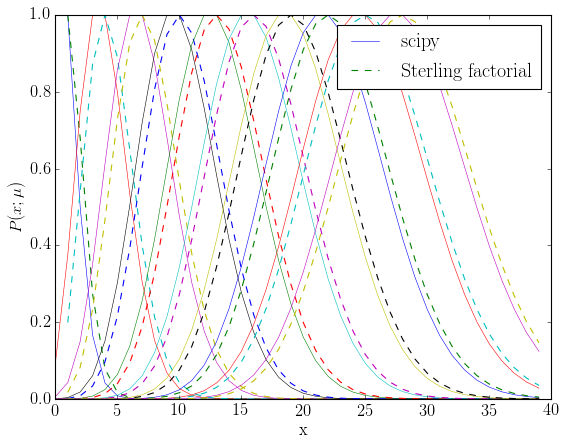

In [1115]:
x = np.arange(0,40,1)
for mu in range(1,30,3): 
    pdist1 = poisson.pmf(x, mu)
    pdist1 = pdist1/max(pdist1)
    pdist2 = poisson_approx(x, mu, method='sterling')
    
    if mu == 1:
        plt.plot(x, pdist1, linewidth=.5, label='scipy')
        plt.plot(x, pdist2, linestyle='dashed', label='Sterling factorial')
    else:
        plt.plot(x, pdist1, linewidth=.5)
        plt.plot(x, pdist2, linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel(r'$P(x;\mu)$')
plt.savefig('writeup/plots/poisson_comparisons.png')
plt.show()

/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


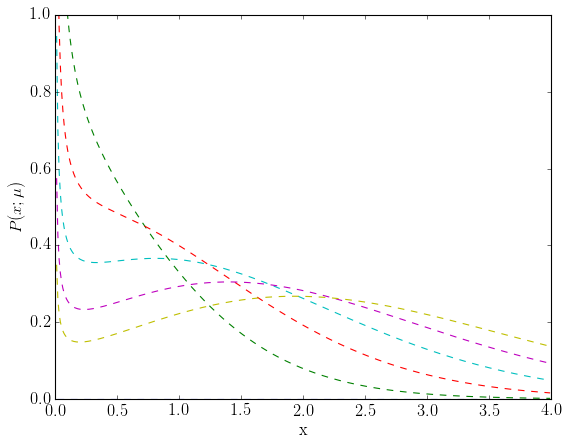

In [982]:
x = np.arange(0,4,.01)
for mu in np.arange(0,3,.5): 
    pdist1 = poisson.pmf(x, mu)
    pdist2 = poisson_approx(x, mu, method='sterling')
#     plt.plot(x, pdist1)
    plt.plot(x, pdist2, linestyle='dashed')
plt.ylim(0,1)
plt.xlabel('x')
plt.ylabel(r'$P(x;\mu)$')
plt.show()

In [ ]:
divide data by max, then fit poisson, then multiply back by max, then plot

In [512]:
def readData(folder):
    """
    Read all frames from a given directory into one matrix.
    input:  directory to folder containing frames
    output: array3d (dimension: xpixel x ypixel x # frames)
            array2D (dimension: 1D flattened img x # frames)
    """
    
    files = os.listdir(folder)

    array3D, array2D = [], []
    for ff in files:
        arr = fits.getdata(folder + ff)
        array3D.append(arr)
        array2D.append(arr.flatten())
    
    return np.array(array3D)

def combineFrame(data_array):
    """
    Combine image frames and return 1D array.
    input:  data array (dimension: # 1D detector counts x # frames)
    output: 1D combined array of detector counts (ADU)
    """
    
    return np.median(data_array, axis=0)

def cutData(array, **kwargs):
    
    avg = mean(array)
    std = stdev(array)
    arr_rng = [min(array), max(array)]
    
    if 'sigma' in kwargs:
        sigma = kwargs.get('sigma')
        low = int(np.round((avg-sigma*std)))
        high = int(np.round((avg+sigma*std)))
        cut = kwargs.get('cut', [low, high])
    elif 'rng' in kwargs:
        cut = kwargs.get('rng')
    else:
        cut = kwargs.get('cut', arr_rng)
    pixel_keep = np.where((array > cut[0]) & (array < cut[1]))[0]
    
    cut_array = array[pixel_keep]
    per_rem = np.round((1 - len(cut_array)/len(array))*100,2)
    print('Cut from range %s to %s, removing %s percent of data points'%(arr_rng, cut, per_rem))
    
    return cut_array

In [1098]:
def plotAll(array2D, **kwargs):
    
    arr = array2D.flatten()
    
    avg = mean(arr)
    std = stdev(arr)
    med = median(arr)
    Npix = len(arr)    
    
    sigma = kwargs.get('sigma', 2)
    low = int(np.round((avg-sigma*std)))
    high = int(np.round((avg+sigma*std)))
    rng = kwargs.get('rng', [low, high])
    exp = kwargs.get('exp')
    if 'nbins' in kwargs:
        nbins = kwargs.get('nbins')
        bin_size = (rng[1]-rng[0])/nbins
    else:
        bin_size = kwargs.get('bin_size', 1)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,6])
    
    # Histogram
    #===========
    hr = np.arange(rng[0], rng[1]+1, bin_size)
    hist = []
    for i in range(len(hr)):
        try:
            counts = len(np.where((arr >= hr[i]) & (arr < hr[i+1]))[0])
        except:
            counts = 0
        hist.append(counts)
    ax1.step(hr, hist, color='k')

    #mean and median lines
    ax1.axvline(avg, color='b', label=r'$\bar{x}=%s$'%(np.round(avg,2)))
    ax1.axvline(med, color='b', label=r'$\tilde{x}=%s$'%(np.round(med,2)), linestyle='dashed')
    
    #sigma levels
    if kwargs.get('show_level', True) == True:
        for i in np.arange(1,sigma+1):
            if i == 1:
                ax1.axvspan(avg-i*std, avg+i*std, facecolor='g', alpha=0.05, label=r'$s=\pm %s$'%(np.round(std,2)))
            else:
                ax1.axvspan(avg-i*std, avg+i*std, facecolor='g', alpha=0.05)
                
                
    #poisson distribution
    xarray = np.arange(rng[0]-10, rng[1]+10, 1)
    pdist = poisson.pmf(xarray, avg)
    pdist = max(hist)/max(pdist)*pdist
    ax1.plot(xarray, pdist, color='r', label=r'$P_{Poisson}(x;\bar{x})$')
#     std_expected = math.sqrt(avg)
#     ax1.axvspan(avg - std_expected, avg + std_expected, facecolor='r', alpha=0.05, \
#                 label=r'$\sigma=\pm %s$'%(np.round(std_expected,2)))
    
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Counts (ADU)')
    ax1.set_ylabel('Frequency')
    
    if 'exp' in kwargs:
        ax1.set_title('Combined Histogram (Exposure Time: %s sec)'%(exp))
    ax1.set_xlim(rng)
    
    # Image
    #===========
    hrng = kwargs.get('hrng', [np.percentile(arr, 10), np.percentile(arr, 90)])
    pl = ax2.imshow(array2D, origin='lower', interpolation='nearest', cmap='gray', vmin=hrng[0], vmax=hrng[1])
    fig.colorbar(pl, ax=ax2, fraction=0.046, pad=0.04).set_label('Detector Value (ADU)')
    
    ax2.set_xlabel('pixels(x)')
    ax2.set_ylabel('pixels(y)')
    ax2.set_title('Combined Image')
    
    if 'save_dir' in kwargs:
        save_dir = kwargs.get('save_dir')
        plt.savefig(save_dir + 'exposure%s.png'%(exp))
    plt.show()

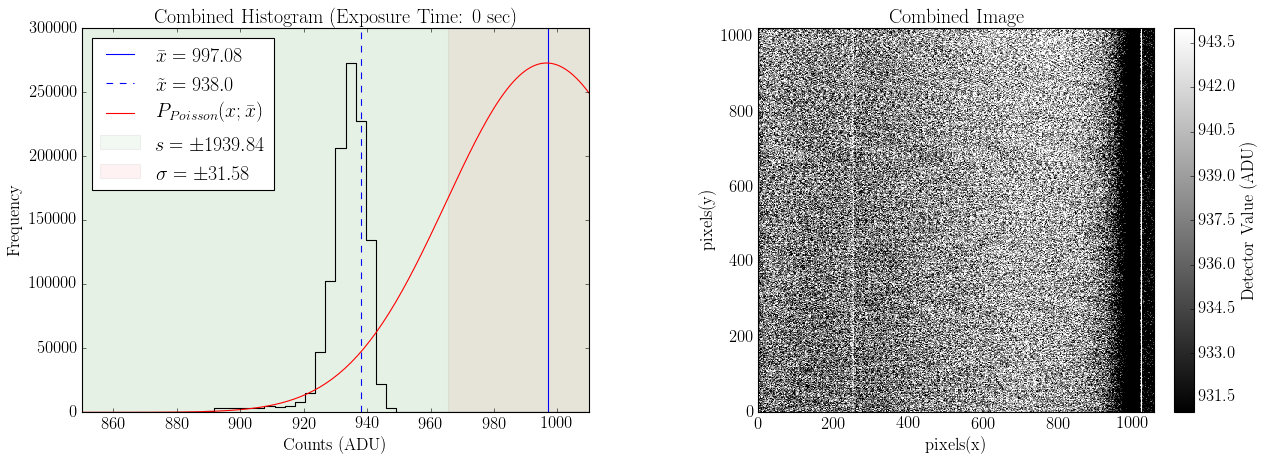

In [1090]:
array3D = readData('data/exp0/')
bias_2D = combineFrame(array3D)
plotAll(bias_2D, rng=[850,1010], nbins=50, exp=0, save_dir='writeup/plots/')

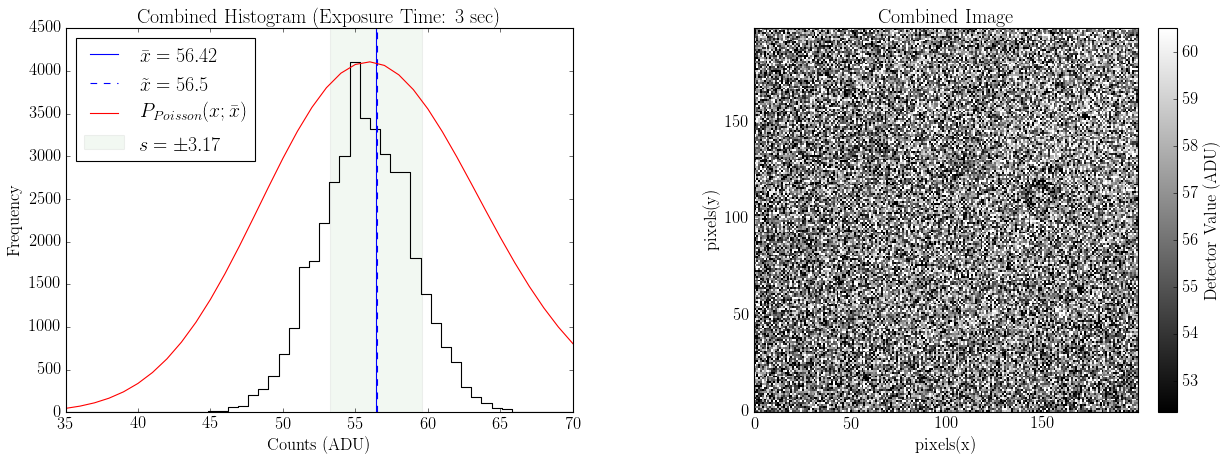

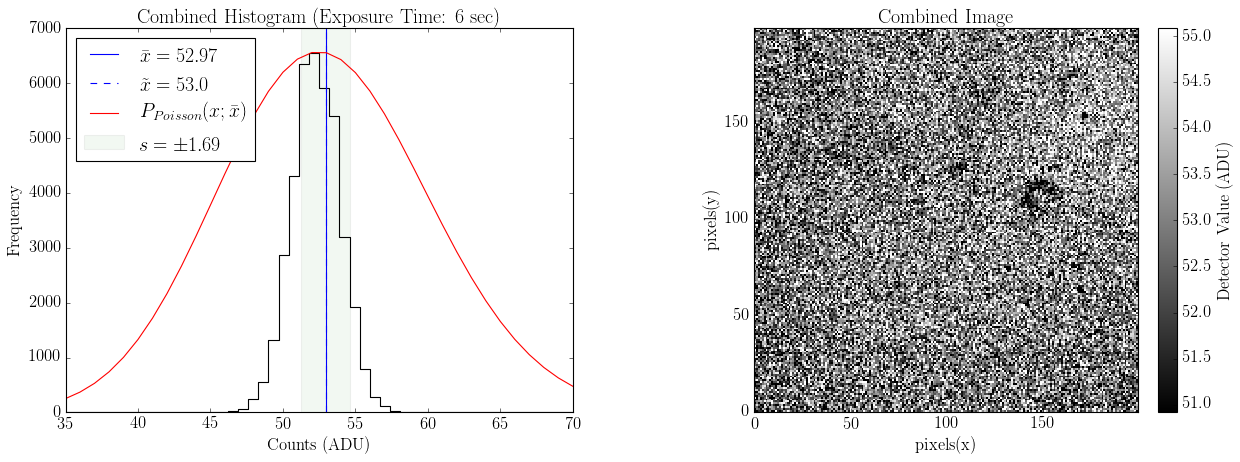

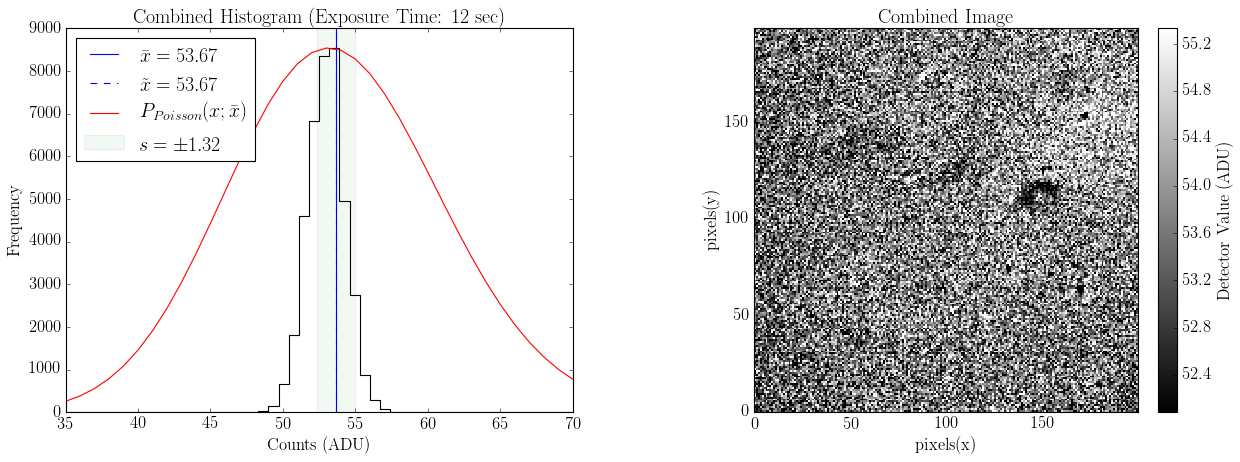

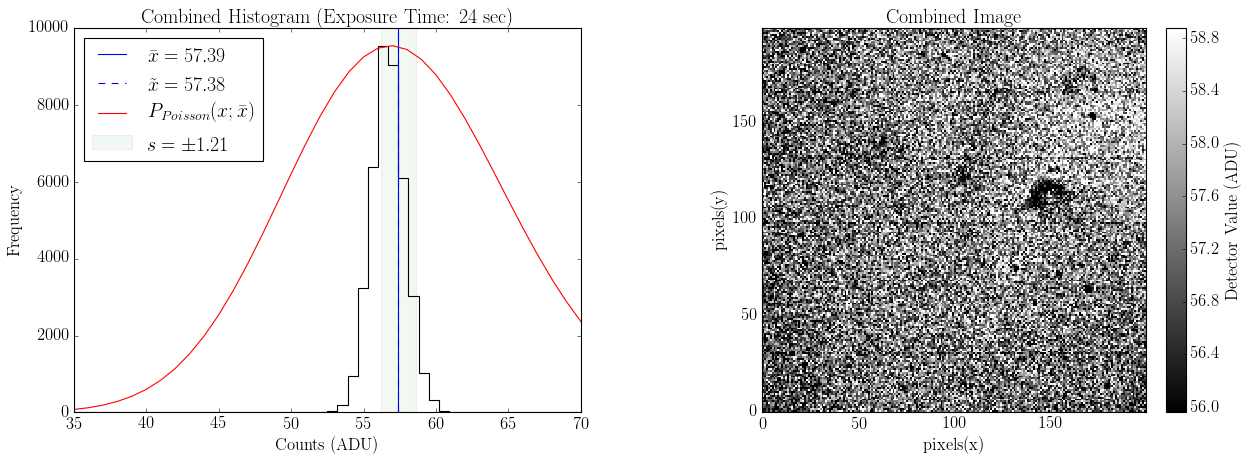

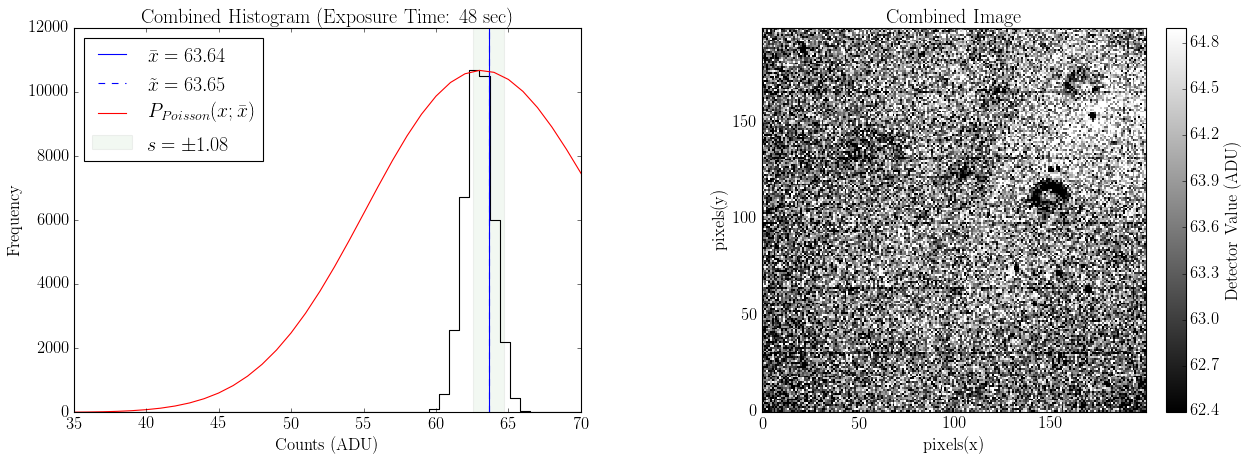

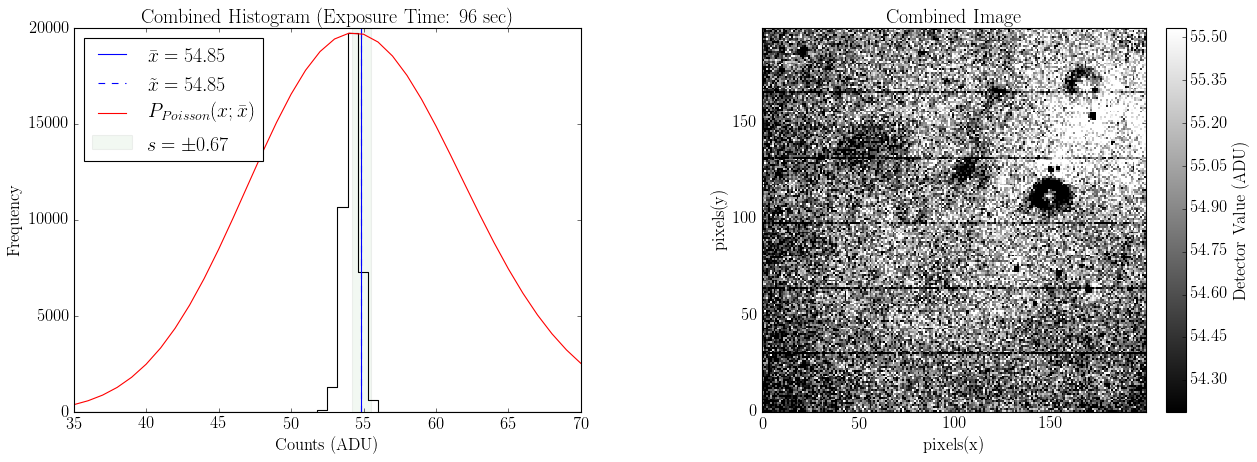

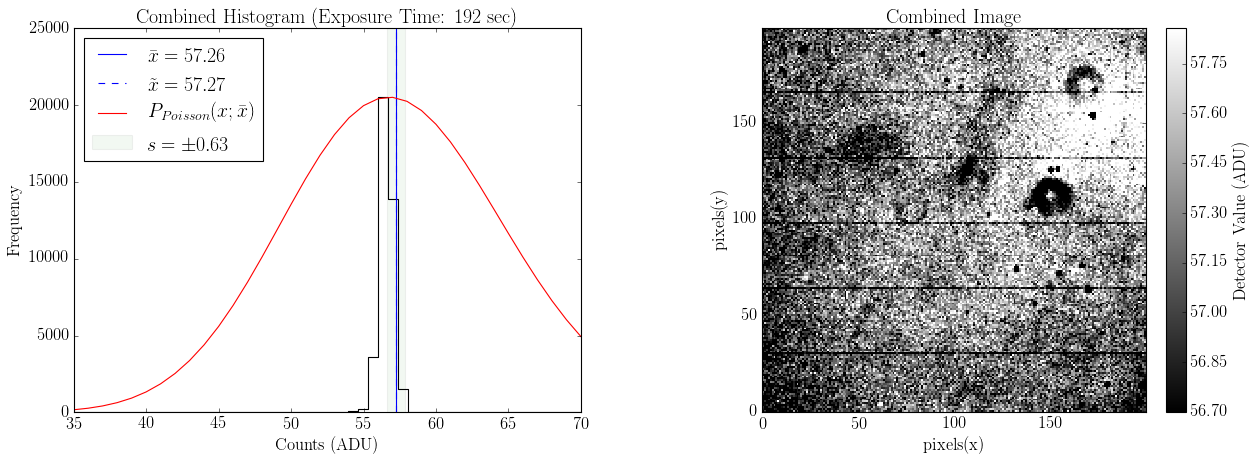

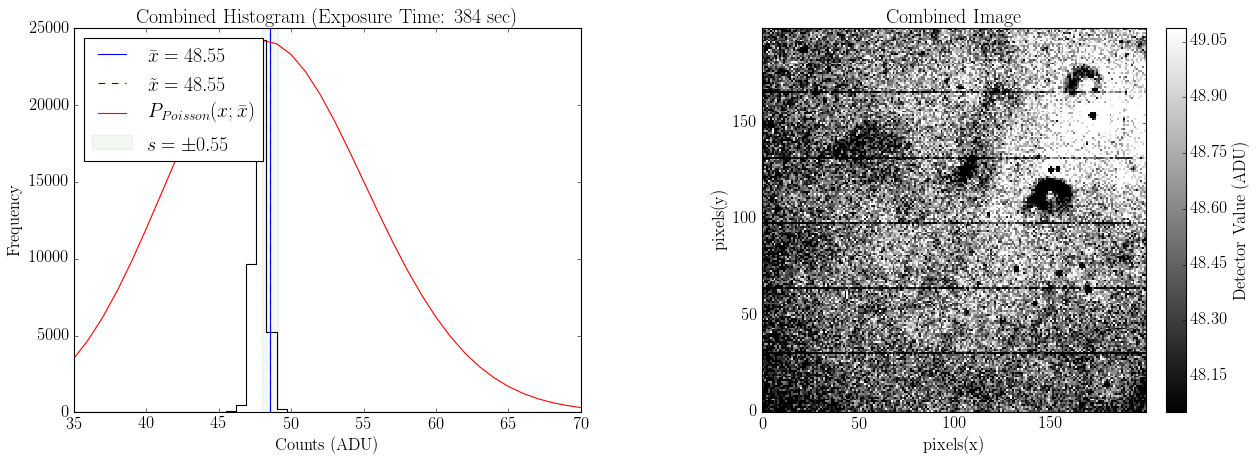

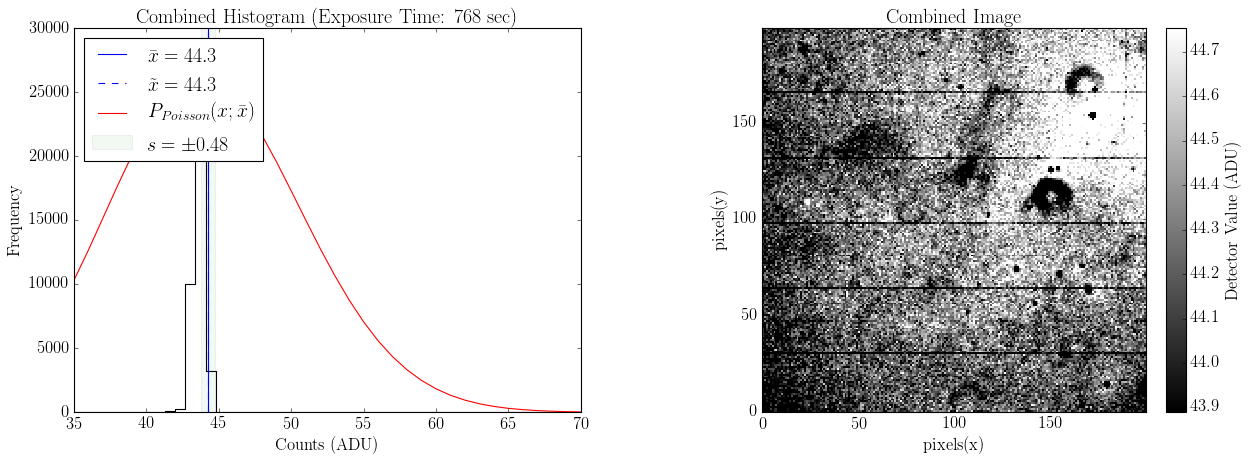

In [1102]:
files = natsorted(os.listdir('data/'))[1:]
exp_times = np.array([int(f.split('exp')[1]) for f in files])

#combined frames, and combined frames in counts per second
frames, cps = [], []
for exp in exp_times:
    
    #Read frames, combine, and subtract combined bias frame
    array3D = readData('data/exp%s/'%(exp))
    #divide by exposure time
    array2D = combineFrame(array3D) - bias_2D
    
    array2D_cps = array2D/exp
    
    #cut out safe part of image
    cut = Cutout2D(array2D_cps, (450,450), (200,200)).data
    
    frames.append(cut.flatten())
    
    #Plot histogram and image & save to .png
    plotAll(cut, sigma=1, rng=[35,70], nbins=50, exp=exp, save_dir='writeup/plots/', show_level=True)

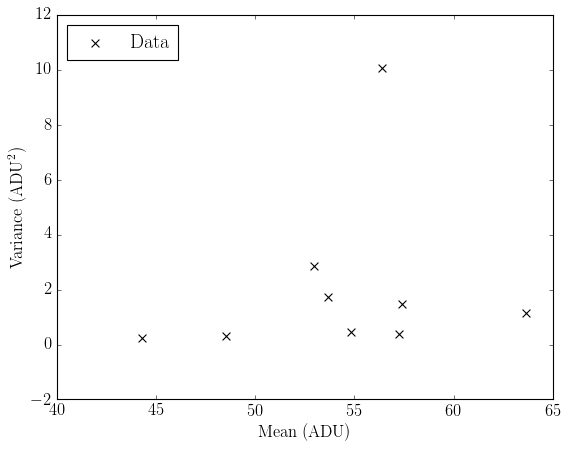

In [1095]:
xbar = np.array([np.mean(f) for f in frames])
s = np.array([np.std(f) for f in frames])

xyline = np.arange(10**2, 10**5, 10**3)

plt.scatter(xbar, s**2, marker='x', s=50, color='k', label='Data')
# plt.plot(xyline, xyline, label=r'$\bar{x}=\sigma^2$')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(10**2, 10**5)
# plt.ylim(10**2, 10**8)
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU$^2$)')
plt.legend(loc='upper left', scatterpoints=1)
plt.savefig('writeup/plots/mean_vs_variance.png')
plt.show()

/home/jess/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


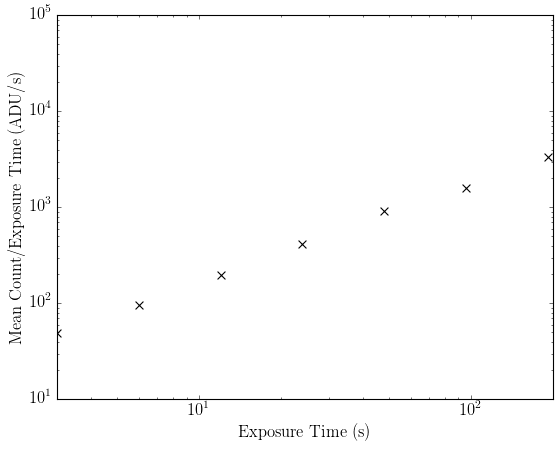

In [936]:
#counts per second
cps = np.array([np.mean(f/exp_times[0]) for f in frames])

plt.scatter(exp_times, cps, marker='x', s=50, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Exposure Time (s)')
plt.ylabel('Mean Count/Exposure Time (ADU/s)')
plt.xlim(0,200)
plt.savefig('writeup/plots/exptime_vs_meancount.png')
plt.show()

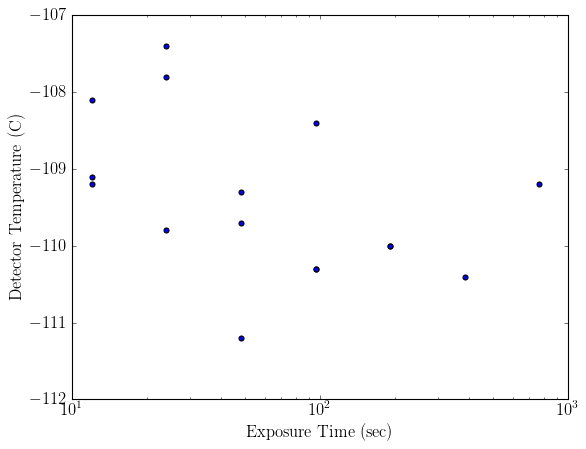

In [995]:
etime, temp = [], []
for exp in os.listdir('data/'):
    fdir = 'data/%s/'%(exp)
    for file in os.listdir(fdir):
        hdr = fits.open(fdir + file)
        data = np.array(hdr[0].data).flatten()
        etime.append(hdr[0].header['EXPTIME'])
        temp.append(hdr[0].header['TEMPDET'])
        
plt.scatter(etime, temp)
plt.xscale('log')
plt.xlabel('Exposure Time (sec)')
plt.ylabel('Detector Temperature (C)')
plt.xlim(10,1000)
plt.savefig('writeup/plots/exposure_temp.png')
plt.show()

In [941]:
hdr[0].header

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                 1056 / NUMBER OF COLUMNS                              
NAXIS2  =                 1024 / NUMBER OF ROWS                                 
CRVAL1U =                 2048 / COLUMN ORIGIN                                  
CRVAL2U =                 2048 / ROW ORIGIN                                     
CDELT1U =                   -2 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                   -2 / ROW CHANGE PER PIXEL                           
OBSNUM  =                  402 / OBSERVATION NUMBER                             
IDNUM   =                    7 / IMAGE ID                                       
UGEOM   =                    0 / UCAM READOUT GEOMETRY                          
DGEOM   =                   